In [1]:


!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

%load_ext nvcc_plugin
     


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-0dxbaghb
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-0dxbaghb
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4287 sha256=f58e661aea639863c158183e78049c8711f90c0bf7747f9761500205a98c8f21
  Stored in directory: /tmp/pip-ephem-wheel-cache-sjy42zty/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [40]:

%%cu

#include <iostream>
#include <fstream>
#include <iomanip>
using namespace std;

struct Grid {
    const size_t N = 6;  // Number of vertical segments
    const size_t M = 6;  // Number of horizontal segments

    const double x_min = 0.0;    // Minimum x-value
    const double x_max = 1.0;    // Maximum x-value
    const double y_min = 0.0;    // Minimum y-value
    const double y_max = 1.0;    // Maximum y-value

    const double x_left_bound = 0.0;    // Dirichlet condition at x = x_min
    const double x_right_bound = 0.0;   // Dirichlet condition at x = x_max
    const double y_bottom_bound = 1.0;  // Dirichlet condition at y = y_min
    const double y_top_bound = 0.0;     // Dirichlet condition at y = y_max

    const double dx = (x_max - x_min) / M;   // Grid spacing in x direction
    const double dy = (y_max - y_min) / N;   // Grid spacing in y direction

    const size_t num_rows = N - 1, num_cols = M - 1;
};

void create_system(Grid& grid, double *matrix_A, double *vector_b) {
    for (int i = 0; i < grid.num_cols; ++i) {
        for (int j = 0; j < grid.num_rows; ++j) {
            matrix_A[(i*grid.num_rows+j)*(grid.num_rows*grid.num_cols)+i*grid.num_rows+j] = -2 * (grid.dx*grid.dx + grid.dy*grid.dy);
            if (i == 0) vector_b[i*grid.num_rows + j] -= grid.dy*grid.dy * grid.x_left_bound;
            else matrix_A[(i*grid.num_rows+j)*(grid.num_rows*grid.num_cols)+(i-1)*grid.num_rows+j] = grid.dy*grid.dy;
            if (i == grid.num_cols-1) vector_b[i*grid.num_rows + j] -= grid.dy*grid.dy * grid.x_right_bound;
            else matrix_A[(i*grid.num_rows+j)*(grid.num_rows*grid.num_cols)+(i+1)*grid.num_rows+j] = grid.dy*grid.dy;
            if (j == 0) vector_b[i*grid.num_rows + j] -= grid.dx*grid.dx * grid.y_bottom_bound;
            else matrix_A[(i*grid.num_rows+j)*(grid.num_rows*grid.num_cols)+i*grid.num_rows+j-1] = grid.dx*grid.dx;
            if (j == grid.num_rows-1) vector_b[i*grid.num_rows + j] -= grid.dx*grid.dx * grid.y_top_bound;
            else matrix_A[(i*grid.num_rows+j)*(grid.num_rows*grid.num_cols)+i*grid.num_rows+j+1] = grid.dx*grid.dx;
        }
    }
}

double * create_field(Grid& grid, double* x) {
    double * u = new double[(grid.N+1)*(grid.M+1)]();
    for (size_t i = 0; i <= grid.N; ++i)
        u[i*(grid.M+1)] = grid.x_left_bound, u[i*(grid.M+1) + grid.M] = grid.x_right_bound;
    for (size_t i = 0; i <= grid.M; ++i)
        u[i] = grid.y_bottom_bound, u[(grid.N+1)*grid.M + i] = grid.y_top_bound;
    for (size_t i = 0; i < grid.num_cols; ++i)
      for (size_t j = 0; j < grid.num_rows; ++j)
          u[(j+1)*(grid.M+1)+i+1] = x[i*grid.num_rows + j];
    return u;
}

void print_field(Grid& grid, double* u) {
    for (int i = grid.N; i >= 0; --i) {
        for (int j = 0; j < grid.M+1; ++j) {
            std::cout << setprecision(7)<< u[i*(grid.M+1) +j] ;
            std::cout << " \t  ";
        }
        std::cout << std::endl;
    }
}

void save_to_file(Grid& grid, double* u) {
    std::ofstream f("out.txt");
    for (int i = grid.N; i >= 0; --i) {
        for (int j = 0; j < grid.M+1; ++j) {
            f << u[i*(grid.M+1) +j] << " ";
        }
        f << std::endl;
    }
    std::cout << "Succesfully saved to './out.txt'" << std::endl;
}



__device__ int max_elem_idx;

__global__ void findMaxInColumn(double* matrix, int n, int col) {
  int max_idx = col;
  double max_val = std::fabs(matrix[col * n + col]);
  double curr_val;

  // Loop through the rows below the given row to find the maximum element
  for (int i = col + 1; i < n; i++) {
    curr_val = std::fabs(matrix[i * n + col]);
    if (curr_val > max_val) {
      max_idx = i;
      max_val = curr_val;
    }
  }

  // Store the index of the maximum element in a global variable
  max_elem_idx = max_idx;
}

__global__ void swapRows(double* matrix, double* identity, int n, int row) {
  // If the given row is already the one with the maximum element, no need to swap
  if (row == max_elem_idx) {
    return;
  }

  // Calculate the index and offset for each thread
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  int offset = gridDim.x * blockDim.x;

  double temp;
  // Loop through the columns and swap the elements of the two rows
  for (; idx < n; idx += offset) {
    temp = matrix[row * n + idx];
    matrix[row * n + idx] = matrix[max_elem_idx * n + idx];
    matrix[max_elem_idx * n + idx] = temp;

    temp = identity[row * n + idx];
    identity[row * n + idx] = identity[max_elem_idx * n + idx];
    identity[max_elem_idx * n + idx] = temp;
  }
}



// Gaussian elimination on the matrix to reduce it to row echelon form
// Subtract the values below the pivot in each column

__global__ void subtract_below(double* matrix, double* identity, int size, int pivot) {
  int x = blockIdx.x * blockDim.x + threadIdx.x;
  int y = blockIdx.y * blockDim.y + threadIdx.y;
  int offset_x = gridDim.x * blockDim.x;
  int offset_y = gridDim.y * blockDim.y;

  int i, j;
  double coefficient;
  // Loop through the rows below the pivot row
  for (i = pivot + 1 + x; i < size; i += offset_x) {
    // Calculate the coefficient to multiply the pivot row by
    coefficient = matrix[i * size + pivot] / matrix[pivot * size + pivot];
    // Loop through the columns to subtract the values
    for (j = pivot + 1 + y; j < size; j += offset_y) {
      matrix[i * size + j] -= coefficient * matrix[pivot * size + j];
    }
    // Loop through the columns of the identity matrix to subtract the values
    for (j = y; j < size; j += offset_y) {
      identity[i * size + j] -= coefficient * identity[pivot * size + j];
    }
  }
}

// Nullify the values below the pivot in each column
__global__ void nullify_below(double* matrix, int size, int pivot) {
  int x = blockIdx.x * blockDim.x + threadIdx.x;
  int offset_x = gridDim.x * blockDim.x;
  // Loop through the rows below the pivot row
  for (int i = pivot + 1 + x; i < size; i += offset_x) {
    // Set the value to 0
    matrix[i * size + pivot] = 0.0;
  }
}

// Subtract the values above the pivot in each column
__global__ void subtract_above(double* matrix, double* identity, int size, int pivot) {
  int x = blockIdx.x * blockDim.x + threadIdx.x;
  int y = blockIdx.y * blockDim.y + threadIdx.y;
  int offset_x = gridDim.x * blockDim.x;
  int offset_y = gridDim.y * blockDim.y;

  int i, j;
  double coefficient;
  // Loop through the rows above the pivot row
  for (i = pivot - 1 - x; i >= 0; i -= offset_x) {
    // Calculate the coefficient to multiply the pivot row by
    coefficient = matrix[i * size + pivot] / matrix[pivot * size + pivot];
    // Loop through the columns to subtract the values
    for (j = pivot - 1 - y; j >= 0; j -= offset_y) {
      matrix[i * size + j] -= coefficient * matrix[pivot * size + j];
    }
    // Loop through the columns of the identity matrix to subtract the values
    for (j = y; j < size; j += offset_y) {
      identity[i * size + j] -= coefficient * identity[pivot * size + j];
    }
  }
}



//Global function to set all elements above the diagonal to zero

__global__ void nullifyAboveDiagonal(double* matrix, int n, int x) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  int offset_x = gridDim.x  * blockDim.x;
  
  // Iterate over the rows above the current row x and set all elements to zero
  for (int i = x - idx - 1; i >= 0; i -= offset_x) {
    matrix[i * n + x] = 0.0;
  }
}

// Global function to divide each element of the identity matrix by the corresponding element of the matrix being transformed
__global__ void divideIdentity(double* matrix, double* identity, int n) {
  int idx = blockIdx.x  * blockDim.x + threadIdx.x;
  int idy = blockIdx.y  * blockDim.y + threadIdx.y;
  int offset_x = gridDim.x * blockDim.x;
  int offset_y = gridDim.y * blockDim.y;
  
  // Iterate over the rows and columns of the matrices and divide corresponding elements
  for (int i = idx; i < n; i += offset_x) {
    for (int j = idy; j < n; j += offset_y) {
      identity[i * n + j] /= matrix[i * n + i];
    }
  }
}

// Global function to set the diagonal elements to 1.0
__global__ void SetDiagonalToOne(double* matrix, int n) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  int offset_x = gridDim.x * blockDim.x;
  
  // Iterate over the diagonal elements and set them to 1.0
  for (int i = idx; i < n; i += offset_x) {
    matrix[i*  n + i] = 1.0;
  }
}


void InverseGPU(double* matrix, double* identity, int n) {
// Define the dimensions of the CUDA blocks and threads.
dim3 BLOCKS_1D(8);
dim3 THREADS_1D(32);
dim3 BLOCKS_2D(8, 8);
dim3 THREADS_2D(32, 32);

// Allocate memory on the device for the input matrix and identity matrix.
double* dev_input_matrix;
double* dev_identity_matrix;
cudaMalloc(&dev_input_matrix, sizeof(double) * n * n);
cudaMalloc(&dev_identity_matrix, sizeof(double) * n * n);

// Copy the input matrix and identity matrix from the host to the device.
cudaMemcpy(dev_input_matrix, matrix, sizeof(double) * n * n,
           cudaMemcpyHostToDevice);
cudaMemcpy(dev_identity_matrix, identity, sizeof(double) * n * n,
           cudaMemcpyHostToDevice);

// Create CUDA events to measure the execution time of the function.
cudaEvent_t begin, end;
cudaEventCreate(&begin);
cudaEventCreate(&end);
cudaEventRecord(begin, 0);

// Forward pass: perform Gaussian elimination to transform the input matrix into an upper triangular matrix.
for (int i = 0; i < n; i++) {
  // Find the maximum element in the current column and swap its row with the current row.
  findMaxInColumn<<<1, 1>>>(dev_input_matrix, n, i);
  swapRows<<<BLOCKS_1D, THREADS_1D>>>(dev_input_matrix, dev_identity_matrix, n, i);

  // Subtract multiples of the current row from all rows below it to eliminate elements below the diagonal.
  subtract_below<<<BLOCKS_2D, THREADS_2D>>>(dev_input_matrix, dev_identity_matrix, n, i);

  // Set all elements below the diagonal in the current column to 0.
  nullify_below<<<BLOCKS_1D, THREADS_1D>>>(dev_input_matrix, n, i);
}

// Backward pass: perform back-substitution to transform the upper triangular matrix into a diagonal matrix.
for (int i = n - 1; i >= 0; i--) {
  // Subtract multiples of the current row from all rows above it to eliminate elements above the diagonal.
  subtract_above<<<BLOCKS_2D, THREADS_2D>>>(dev_input_matrix, dev_identity_matrix, n, i);

  // Set all elements above the diagonal in the current column to 0.
  nullifyAboveDiagonal<<<BLOCKS_1D, THREADS_1D>>>(dev_input_matrix, n, i);
}

// Divide each element in the identity matrix by the corresponding element in the input matrix.
divideIdentity<<<BLOCKS_2D, THREADS_2D>>>(dev_input_matrix, dev_identity_matrix, n);

// Divide each element in the input matrix by the corresponding diagonal element to set all diagonal elements to 1.
SetDiagonalToOne<<<BLOCKS_1D, THREADS_1D>>>(dev_input_matrix, n);

// Record the execution time and destroy the CUDA events.
cudaEventRecord(end, 0);
cudaEventSynchronize(end);
float t;
cudaEventElapsedTime(&t, begin, end);
std::cout <<"Time taken for inversion: " << t << std::endl;
cudaEventDestroy(begin);
cudaEventDestroy(end);

// Copy the inverted matrix and identity matrix from the device to the host.
cudaMemcpy(matrix, dev_input_matrix, sizeof(double) * n * n,
           cudaMemcpyDeviceToHost);
cudaMemcpy(identity, dev_identity_matrix, sizeof(double) * n * n,
           cudaMemcpyDeviceToHost);

// Free the memory allocated on the device.
cudaFree(dev_input_matrix);
cudaFree(dev_identity_matrix);
}


// Function to perform matrix-vector multiplication

__global__ void MatrixVectorMult(double *mat, double *vec, double *res, int size) {
    // Calculate the row index based on the thread and block dimensions
    int row_idx = threadIdx.x + blockDim.x * blockIdx.x;
    // Initialize the sum to 0
    double sum = 0;
   
    // If the row index is within the bounds of the matrix
    if(row_idx < size) {
        // Iterate over each column in the row
        for(int col_idx = 0; col_idx < size; col_idx++) {
            // Multiply the matrix value by the corresponding vector value and add it to the sum
            sum += mat[row_idx * size + col_idx] * vec[col_idx];
        }
    }
    
    // Store the sum in the corresponding index of the result array
    res[row_idx] = sum;
}


void MatrixVectorMultiplicationGPU(double* mat, double* vec, double* res, int n) {
  // determine the number of threads and blocks to use
  int THREADS_PER_BLOCK = std::min(n, 512);
  int BLOCKS_PER_GRID = std::ceil((1.0 * n) / THREADS_PER_BLOCK);
  dim3 BLOCKS_2D(BLOCKS_PER_GRID, BLOCKS_PER_GRID);
  dim3 THREADS_2D(THREADS_PER_BLOCK, THREADS_PER_BLOCK);

  // allocate memory on the device and copy matrix and vector to the device
  double *d_matrix, *d_vec, *d_res;
  cudaMalloc(&d_matrix, sizeof(double) * n * n);
  cudaMalloc(&d_vec, sizeof(double) * n);
  cudaMalloc(&d_res, sizeof(double) * n);
  cudaMemcpy(d_matrix, mat, sizeof(double) * n * n, cudaMemcpyHostToDevice);
  cudaMemcpy(d_vec, vec, sizeof(double) * n, cudaMemcpyHostToDevice);

  // measure the time spent on the GPU
  cudaEvent_t begin, end;
  cudaEventCreate(&begin);
  cudaEventCreate(&end);
  cudaEventRecord(begin, 0);

  // launch the kernel that performs the matrix-vector multiplication
  MatrixVectorMult<<<BLOCKS_2D, THREADS_2D>>>(d_matrix, d_vec, d_res, n);

  // measure the elapsed time and print it
  cudaEventRecord(end, 0);
  cudaEventSynchronize(end);
  float elapsed_time;
  cudaEventElapsedTime(&elapsed_time, begin, end);
  std::cout <<"Time taken for MatVec operation: " << elapsed_time << std::endl;

  // destroy the events and copy the result back to the host
  cudaEventDestroy(begin);
  cudaEventDestroy(end);
  cudaMemcpy(res, d_res, sizeof(double) * n, cudaMemcpyDeviceToHost);

  // free memory on the device
  cudaFree(d_matrix);
  cudaFree(d_vec);
  cudaFree(d_res);
}



int main() {

    struct Grid my_grid;
    double * Matrx_A = new double[my_grid.num_rows*my_grid.num_cols*my_grid.num_rows*my_grid.num_cols]();
    double * x = new double[my_grid.num_rows*my_grid.num_cols]();
    double * Vector_b = new double[my_grid.num_rows*my_grid.num_cols]();
/* (Grid& grid, double *matrix_A, double *vector_b)    
*/    
    create_system(my_grid, Matrx_A, Vector_b);

    double* I = new double[my_grid.num_rows*my_grid.num_cols*my_grid.num_rows*my_grid.num_cols]();  // identity matrix
    for (int i = 0; i < my_grid.num_rows*my_grid.num_cols; i++) I[i * my_grid.num_rows*my_grid.num_cols + i] = 1.0;


    InverseGPU(Matrx_A, I, my_grid.num_rows*my_grid.num_cols); // I = Matrx_A ^ (-1)

    MatrixVectorMultiplicationGPU(I, Vector_b, x, my_grid.num_rows*my_grid.num_cols);


    double * u = create_field(my_grid,x);
    //print_field(my_grid,u);

    save_to_file(my_grid,u);

    delete[] Matrx_A;
    delete[] Vector_b;
    delete[] x;
    delete[] u;
    delete[] I;

    return 0;
}

Time taken for inversion: 1.61888
Time taken for MatVec operation: 0.03136
Succesfully saved to './out.txt'



In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


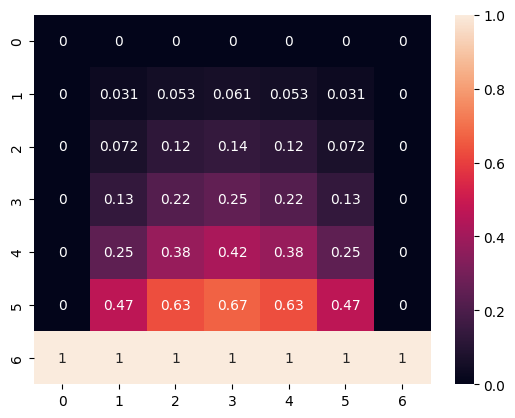

In [43]:

with open('./out.txt', 'r') as file:
  lines_list = [line.strip() for line in file.readlines()]
  field_list = [[float(value) for value in line.split()] for line in lines_list]

heatmap_ax = sns.heatmap(field_list, linewidth=0.0, annot=True)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Image Filtering

In [ ]:

from PIL import Image

image = Image.open('/content/simsps.jpg')
print(f"Original size : {image.size}") 

sunset_resized = image.resize((512, 512))
sunset_resized.save('/content/simps512.jpg')

Original size : (1920, 1080)


In [ ]:


%%writefile filter.cu


#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"

#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"


// Copy a pixel from the input to the output image
__device__ void copyPixel(double *inputImage, double *outputImage, int j, int i, int channel, int width)
{
    outputImage[j * width * 3 + i * 3 + channel] = inputImage[j * width * 3 + i * 3 + channel];
}

// Get the colors of the 121 pixels in the 11x11 neighborhood centered at the given pixel
__device__ void getPixelColors(double *inputImage, int j, int i, int channel, int width, double *pixelColors)
{
    int count = 0;
    for (int k = -5; k < 6; k++)
    {
        for (int l = -5; l < 6; l++)
        {
            pixelColors[count] = inputImage[(j + l) * width * 3 + (i + k) * 3 + channel];
            count++;  
        }
    }
}

// Sort an array of colors in descending order
__device__ void sortColors(double *pixelColors)
{
    double x = 0;
    for (int k = 0; k < 120; k++)
    {
        for (int l = k + 1; l < 121; l++)
        {
            if (pixelColors[k] < pixelColors[l])
            {
                x = pixelColors[k];
                pixelColors[k] = pixelColors[l];
                pixelColors[l] = x;
            }
        }
    }
}

// Set the value of the output pixel to the 61st color value
__device__ void setOutputPixel(double *outputImage, int j, int i, int channel, int width, double *pixelColors)
{
    outputImage[j * width * 3 + i * 3 + channel] = pixelColors[60];
}


// Define the NonLinearFilter kernel function
__global__ void NonLinearFilter(int height, int width, double *inputImage, double *outputImage)
{
    // Calculate the global index of the current thread
    int globalIndex = threadIdx.x + blockDim.x * blockIdx.x;

    // Calculate the j and i indices and the channel number of the corresponding pixel
    int j = globalIndex / width / 3;
    int i = globalIndex / 3 - j * width;
    int channel = globalIndex - i * 3 - j * width * 3;
  
    // Calculate the total number of elements in the input and output arrays
    long int size = height * width * 3;

    if (globalIndex >= size)
    {
        // This thread index is outside of the image boundaries
        return;
    }
    
    if (i < 4 || j < 4 || i > width - 5 || j > height - 5)
    {
        // This pixel is at the edge of the image
        copyPixel(inputImage, outputImage, j, i, channel, width);
    }
    else
    {
        // This pixel is not at the edge of the image
        double pixelColors[121];
        getPixelColors(inputImage, j, i, channel, width, pixelColors);
        sortColors(pixelColors);
        setOutputPixel(outputImage, j, i, channel, width, pixelColors);
    }
}

 

// Copy a pixel from the input to the output image
__device__ void copyPixel2(double *inputImage, double *outputImage, int j, int i, int channel, int width)
{
    outputImage[j * width * 3 + i * 3 + channel] = inputImage[j * width * 3 + i * 3 + channel];
}

// Apply the filter kernel to a pixel
__device__ void applyFilter(double *inputImage, double *outputImage, int j, int i, int channel, int width, double *kernel)
{
    outputImage[j*width*3 + i*3 + channel] =  (inputImage[j*width*3 + i*3 + channel]*kernel[4] + \
                             inputImage[(j + 1) *width * 3 + (i - 1) * 3 + channel]*kernel[0] + \
                             inputImage[(j + 1) *width * 3 + (i + 1) * 3 + channel]*kernel[8] + \
                             inputImage[(j - 1) *width * 3 + (i - 1) * 3 + channel]*kernel[6] + \
                             inputImage[(j - 1) *width * 3 + (i + 1) * 3 + channel]*kernel[2] + \
                             inputImage[(j + 1) *width * 3 + i * 3 + channel]*kernel[3] + \
                             inputImage[j *width * 3 + (i - 1) * 3 + channel]*kernel[1] + \
                             inputImage[(j - 1) *width * 3 + i * 3 + channel]*kernel[5] + \
                             inputImage[j * width * 3 + (i + 1)*3 + channel]*kernel[7]); 
}


// Define the Filter kernel function
__global__ void Filter(int height, int width, double *kernel, double *inputImage, double *outputImage)
{
    // Calculate the global index of the current thread
    int globalIndex = threadIdx.x + blockDim.x * blockIdx.x;

    // Calculate the j and i indices and the channel number of the corresponding pixel
    int j = globalIndex / width / 3;
    int i = globalIndex / 3 - j * width;
    int channel = globalIndex - i * 3 - j * width * 3; 
  
    // Calculate the total number of elements in the input and output arrays
    long int size = height * width * 3;
  
    // Check if the current thread index is within the bounds of the input and output arrays
    if (globalIndex < size)
    {
        if (i == 0 || j == 0 || i == width - 1 || j == height - 1)
        {
            // If the pixel is at the edge of the image, copy it directly to the output
            copyPixel2(inputImage, outputImage, j, i, channel, width);
        }
        else
        {
            // If the pixel is not at the edge of the image, apply the filter kernel to it
            applyFilter(inputImage, outputImage, j, i, channel, width, kernel);
        }

        // Clamp the output pixel value to be non-negative
        if (outputImage[j * width * 3 + i * 3 + channel] < 0)
        {
            outputImage[j * width * 3 + i * 3 + channel] = 0;
        }
    }
}



//////////////////



int main(int argc, char **argv)
{
  int image_width, image_height, image_bpp, image_size;

  // Allocate memory for the kernel
  double *kernel = (double *) calloc(sizeof(double), 9);

  // Allocate memory for CUDA kernel
  double *cuda_kernel;

  // Allocate memory for filter name
  char *filter_name;

  // Get filter name from command line arguments
  filter_name = (char *) malloc(sizeof(char) * (strlen(argv[1] + 1)));
  filter_name = argv[1];

  // Set kernel values based on filter name
  if (strcmp(filter_name, "edge") == 0)
  {
      kernel[0] = kernel[6] = kernel[2] = kernel[8] = -1;
      kernel[1] = kernel[3] = kernel[7] = kernel[5] = -1;
      kernel[4] = 8;
  }
  
  if (strcmp(filter_name, "gaussian") == 0)
  {
      kernel[0] = kernel[6] = kernel[2] = kernel[8] = 1 / 16.;
      kernel[1] = kernel[3] = kernel[7] = kernel[5] = 2 / 16.;
      kernel[4] = 3 / 50.;
  }

  // Allocate memory for CUDA kernel
  if (strcmp(filter_name, "median") != 0)
  {
      cudaMalloc(&cuda_kernel, sizeof(double)*9);
      cudaMemcpy(cuda_kernel, kernel, sizeof(double) * 9, cudaMemcpyHostToDevice);  
  }

  // Load image
  uint8_t* image = stbi_load("simps512.jpg", &image_width, &image_height, &image_bpp, 3);  
  image_size = image_height * image_width * 3;

  // Allocate memory for image buffer
  double *image_buffer = (double *) malloc(sizeof(double) * image_size);

  // Allocate memory for CUDA image and result buffers
  double *cuda_image;
  double *cuda_result;

  cudaMalloc(&cuda_image, sizeof(double) * image_size);
  cudaMalloc(&cuda_result, sizeof(double) * image_size);

  // Convert image buffer to double
  for (int i = 0; i < image_size; i++) image_buffer[i] = (double) image[i];
  
  // Copy image buffer to CUDA image buffer
  cudaMemcpy(cuda_image, image_buffer, sizeof(double) * image_size, cudaMemcpyHostToDevice);

  // Set block size and grid size for CUDA kernels

  dim3 dimBlock(image_height);
  dim3 dimGrid(image_width * 3);

  // Apply filter based on filter name
  if (strcmp(filter_name, "median") != 0) Filter<<<dimGrid,dimBlock>>>(image_height, image_width, cuda_kernel, cuda_image, cuda_result);
  else NonLinearFilter<<<dimGrid,dimBlock>>>(image_height, image_width, cuda_image, cuda_result);

  // Synchronize CUDA device
  cudaDeviceSynchronize();  
  
  // Copy CUDA result buffer to image buffer
  double *result_buffer = (double *)malloc(sizeof(double) * image_size);
  cudaMemcpy(result_buffer, cuda_result, sizeof(double) * image_size, cudaMemcpyDeviceToHost);
  
  // Convert result buffer to uint8_t and store as image
  for (int i = 0; i < image_size; i++) image[i] = uint8_t (result_buffer[i]);

  // Save filtered image
  stbi_write_png("simps512_fil.png", image_width, image_height, 3, image, image_width * 3);

  // Free memory
  free(image);
  free(image_buffer);
  cudaFree(cuda_image);
  cudaFree(cuda_result);
}





Overwriting filter.cu


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvcc filter.cu



stb_image.h(4096): warning #550-D: variable "old_limit" was set but never used

stb_image.h(4975): warning #550-D: variable "idata_limit_old" was set but never used



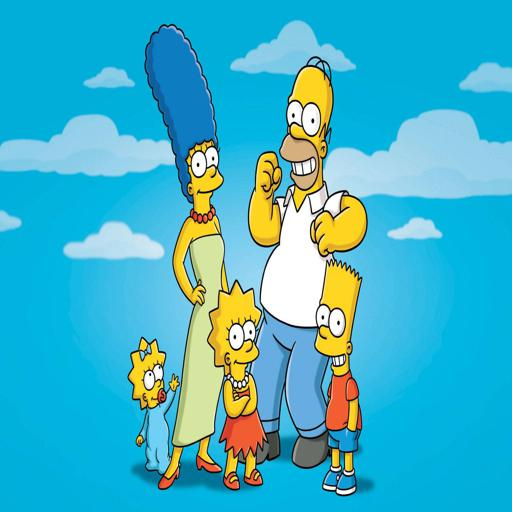

In [ ]:
#### Original Image

from IPython.display import Image 
pil_img = Image(filename='/content/simps512.jpg')
display(pil_img)

In [ ]:
!./a.out gaussian

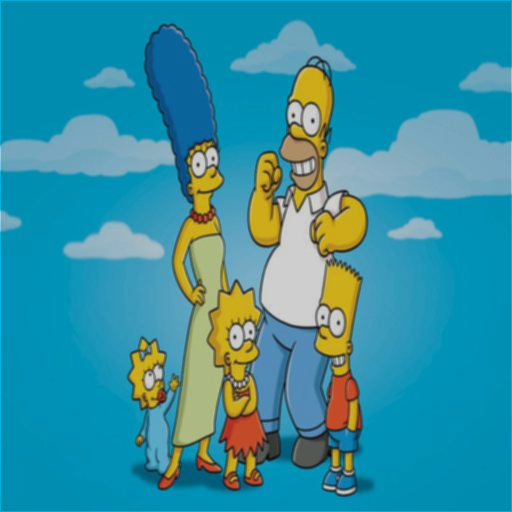

In [ ]:
from IPython.display import Image 
pil_img = Image(filename='/content/simps512_fil.png')
display(pil_img)

In [ ]:
!./a.out edge

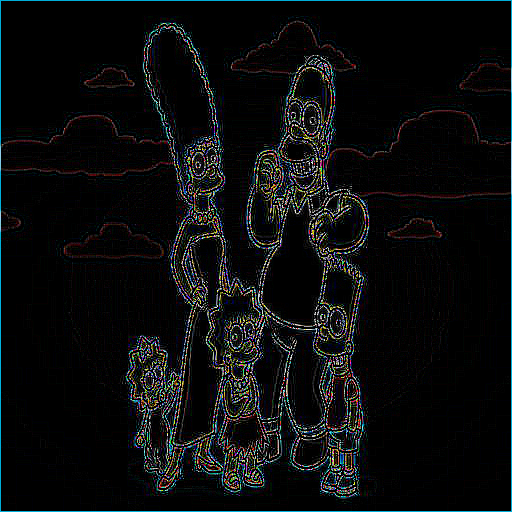

In [ ]:
from IPython.display import Image 
pil_img = Image(filename='/content/simps512_fil.png')
display(pil_img)

In [ ]:
!./a.out median

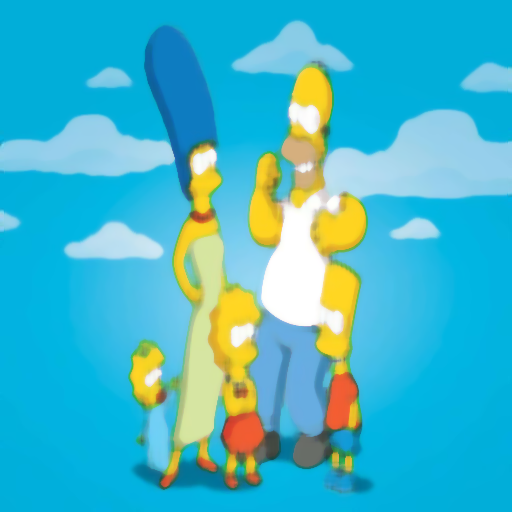

In [ ]:
from IPython.display import Image 
pil_img = Image(filename='/content/simps512_fil.png')
display(pil_img)

# Histogram

In [20]:

%%writefile histogram.cu

#include <stdio.h>
#include <stdint.h>

#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"

#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"

// kernel function to calculate grayscale image and histogram
__global__ void grayScaleAndHistogram(uint8_t *inputImage, unsigned int *histogram, int numBins, int imageWidth, int imageHeight) {
    int threadId = threadIdx.x + blockDim.x * blockIdx.x;
    
    if (threadId < imageWidth * imageHeight) {
        // calculate grayscale value of pixel
        int grayValue = 0;
        for (int channel = 0; channel < 3; channel++) {
            grayValue += inputImage[threadId * 3 + channel];
        }
        grayValue /= 3;

        // increment histogram bin corresponding to pixel intensity
        atomicAdd(&histogram[grayValue % numBins], 1);
        
        // set grayscale value of pixel to output image
        inputImage[threadId * 3] = grayValue;
        inputImage[threadId * 3 + 1] = grayValue;
        inputImage[threadId * 3 + 2] = grayValue;
    }
}

// function to read in input image
uint8_t* readImage(char* filename, int *imageWidth, int *imageHeight) {
    int channels = 3;
    uint8_t* image = stbi_load(filename, imageWidth, imageHeight, &channels, STBI_rgb);
    return image;
}

// function to write histogram data to file
void writeHistogram(char* filename, unsigned int *histogram, int numBins) {
    FILE *file = fopen(filename, "wb");
    for (int i = 0; i < numBins; i++) {
        fprintf(file, "%d\n", histogram[i]);
    }
    fclose(file);
}

int main(void) {
    int numBins = 256;
    int imageWidth, imageHeight;

    // read in input image
    uint8_t* inputImage = readImage("simsps.jpg", &imageWidth, &imageHeight);

    // allocate memory on GPU
    uint8_t* deviceInputImage;
    unsigned int* deviceHistogram;
    cudaMalloc(&deviceInputImage, sizeof(uint8_t) * imageWidth * imageHeight * 3); // allocate space for three channels (RGB)
    cudaMalloc(&deviceHistogram, sizeof(unsigned int) * numBins);

    // copy input image from CPU to GPU
    cudaMemcpy(deviceInputImage, inputImage, sizeof(uint8_t) * imageWidth * imageHeight * 3, cudaMemcpyHostToDevice);
    
    // set block size and grid size for GPU kernel
    int blockSize = 256;
    int gridSize = (imageWidth * imageHeight + blockSize - 1) / blockSize;
    dim3 block(blockSize, 1, 1);
    dim3 grid(gridSize, 1, 1);

    // call GPU kernel to calculate grayscale image and histogram
    grayScaleAndHistogram<<<grid, block>>>(deviceInputImage, deviceHistogram, numBins, imageWidth, imageHeight);
    cudaDeviceSynchronize();
    
    // copy histogram data back from GPU to CPU
    unsigned int* histogram = (unsigned int*)malloc(sizeof(unsigned int) * numBins);
    cudaMemcpy(histogram, deviceHistogram, sizeof(unsigned int) * numBins, cudaMemcpyDeviceToHost);

    // write histogram data to file
    writeHistogram("histogram.txt", histogram, numBins);

    // save grayscale image to disk
    stbi_write_png("output.png", imageWidth, imageHeight, 3, inputImage, 100);

    // free memory on GPU and CPU
    cudaFree(deviceInputImage);
    cudaFree(deviceHistogram);
    free(inputImage);
    free(histogram);

    return 0;
}


Overwriting histogram.cu


In [21]:
!nvcc histogram.cu 

stb_image.h(4096): warning #550-D: variable "old_limit" was set but never used

stb_image.h(4975): warning #550-D: variable "idata_limit_old" was set but never used

histogram.cu(54): warning #2464-D: conversion from a string literal to "char *" is deprecated

histogram.cu(80): warning #2464-D: conversion from a string literal to "char *" is deprecated

histogram.cu(54): warning #2464-D: conversion from a string literal to "char *" is deprecated

histogram.cu(80): warning #2464-D: conversion from a string literal to "char *" is deprecated



In [22]:
!./a.out


In [29]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

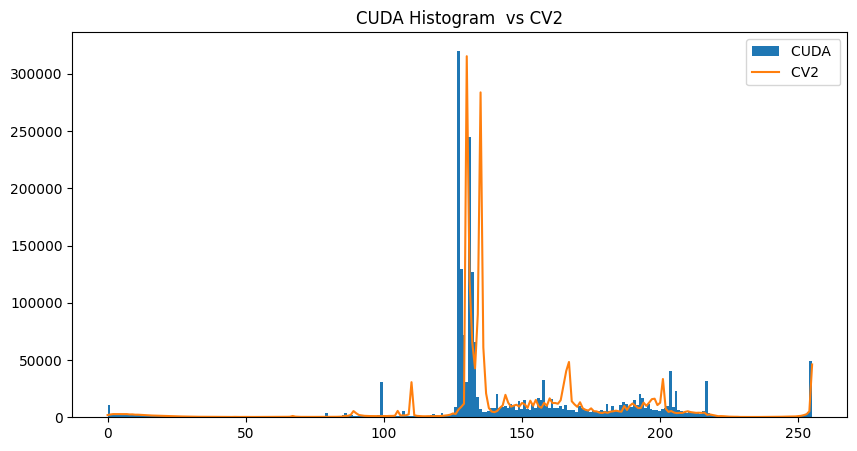

In [32]:
hist_data = []
with open('histogram.txt') as file: 
  for i in file: hist_data.append(int(i))

image = cv2.imread('simsps.jpg', 0)

plt.figure(figsize=(10, 5))
plt.title('CUDA Histogram  vs CV2')
plt.hist(image.flatten(), bins=256, label='CUDA ')
plt.plot(np.arange(256), hist_data, label='CV2 ')
plt.legend();